# Explore output variability

How precise are the estimates of the mean performance measures (occ_mean, occ_p95, pct_wait, pct_blocked, mean and p95 of time wait/blocked)?

How do the variances of the means vary within the input scenario space?

How does the number of replications impact the variances of the means?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import math

sns.set_theme(style="darkgrid")

In [2]:
%matplotlib inline

In [3]:
scenario_rep_summary_df = \
    pd.read_csv('./output/scenario_rep_inputs_summary.csv').sort_values(by=['scenario', 'rep'])

scenario_rep_summary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3750 entries, 0 to 3749
Columns: 102 entries, scenario to rho_pp
dtypes: float64(88), int64(13), object(1)
memory usage: 2.9+ MB


In [4]:
scenario_rep_summary_df.head()

,scenario,rep,timestamp,num_days,num_visits_obs,num_visits_ldr,num_visits_pp,num_visits_csect,planned_los_mean_obs,actual_los_mean_obs,...,acc_tar_pp,load_obs,load_ldr,load_pp,cap_obs,cap_ldr,cap_pp,rho_obs,rho_ldr,rho_pp
0,1,1,2021-07-28 09:11:24.370086,2300.0,6232.0,6233.0,6240.0,1269.0,2.400998,2.569342,...,0.95,0.273973,1.369863,6.027397,4,4,12,0.068493,0.342466,0.502283
1,1,2,2021-07-28 09:19:58.404817,2300.0,6245.0,6248.0,6259.0,1223.0,2.381319,2.573049,...,0.95,0.273973,1.369863,6.027397,4,4,12,0.068493,0.342466,0.502283
2,1,3,2021-07-28 09:19:48.382866,2300.0,6357.0,6357.0,6363.0,1305.0,2.383710,2.597278,...,0.95,0.273973,1.369863,6.027397,4,4,12,0.068493,0.342466,0.502283
3,1,4,2021-07-28 09:24:19.656890,2300.0,6219.0,6222.0,6230.0,1197.0,2.393005,2.550638,...,0.95,0.273973,1.369863,6.027397,4,4,12,0.068493,0.342466,0.502283
4,1,5,2021-07-28 09:21:11.945186,2300.0,6316.0,6316.0,6323.0,1200.0,2.436710,2.598536,...,0.95,0.273973,1.369863,6.027397,4,4,12,0.068493,0.342466,0.502283


Group by scenario and compute means and variances

In [5]:
norm.ppf(0.975)

1.959963984540054

In [6]:
t.ppf(0.975, 24)

2.0638985616280205

In [30]:
def varsum(df, unit, pm, alpha):
    """Summarize variance in performance measure across replications within a scenario"""
    
    # alpha is for construction 1-alpha CI
    # Precision is CI half width / mean and is measure of relative error
       
    pm_varsum_df = df.groupby(['scenario']).agg(
    pm_mean=pd.NamedAgg(column=pm, aggfunc='mean'),
    pm_std=pd.NamedAgg(column=pm, aggfunc='std'),
    pm_n=pd.NamedAgg(column=pm, aggfunc='count'),
    pm_min=pd.NamedAgg(column=pm, aggfunc='min'),
    pm_max=pd.NamedAgg(column=pm, aggfunc='max'))

    pm_varsum_df['pm_cv'] = \
        pm_varsum_df['pm_std'] / pm_varsum_df['pm_mean']
    
    pm_varsum_df['ci_halfwidth'] = \
        t.ppf(1 - alpha / 2, pm_varsum_df['pm_n'] - 1) * pm_varsum_df['pm_std'] / np.sqrt(pm_varsum_df['pm_n'])
    
    pm_varsum_df['ci_precision'] = pm_varsum_df['ci_halfwidth'] / pm_varsum_df['pm_mean']
    
    pm_varsum_df['ci_lower'] = pm_varsum_df['pm_mean'] - pm_varsum_df['ci_halfwidth']
    pm_varsum_df['ci_upper'] = pm_varsum_df['pm_mean'] + pm_varsum_df['ci_halfwidth']
    
    pm_varsum_df['unit'] = unit
    pm_varsum_df['pm'] = pm
    
    return pm_varsum_df
    

### Occ mean and p95 for LDR

In [31]:
occ_mean_ldr_varsum = varsum(scenario_rep_summary_df, 'ldr', 'occ_mean_ldr', 0.05)

occ_mean_ldr_varsum

,pm_mean,pm_std,pm_n,pm_min,pm_max,pm_cv,ci_halfwidth,ci_precision,ci_lower,ci_upper,unit,pm
scenario,,,,,,,,,,,,
1,1.365002,0.021661,25,1.318676,1.398537,0.015869,0.008941,0.006550,1.356061,1.373943,ldr,occ_mean_ldr
2,1.423845,0.026926,25,1.362900,1.474661,0.018911,0.011115,0.007806,1.412731,1.434960,ldr,occ_mean_ldr
3,1.517779,0.034256,25,1.437251,1.587347,0.022570,0.014140,0.009316,1.503638,1.531919,ldr,occ_mean_ldr
4,1.313229,0.019434,25,1.275095,1.343156,0.014798,0.008022,0.006108,1.305207,1.321251,ldr,occ_mean_ldr
5,1.359869,0.022184,25,1.312939,1.399814,0.016313,0.009157,0.006734,1.350712,1.369026,ldr,occ_mean_ldr
...,...,...,...,...,...,...,...,...,...,...,...,...
146,9.565965,0.061970,25,9.435860,9.737057,0.006478,0.025580,0.002674,9.540385,9.591545,ldr,occ_mean_ldr
147,9.556965,0.056537,25,9.454741,9.698210,0.005916,0.023337,0.002442,9.533627,9.580302,ldr,occ_mean_ldr
148,12.296938,0.070614,25,12.181505,12.493293,0.005742,0.029148,0.002370,12.267790,12.326086,ldr,occ_mean_ldr


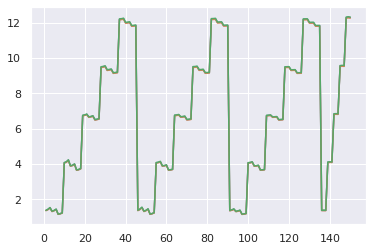

In [32]:
plt.plot(occ_mean_ldr_varsum['pm_mean'])
plt.plot(occ_mean_ldr_varsum['ci_lower'])
plt.plot(occ_mean_ldr_varsum['ci_upper'])

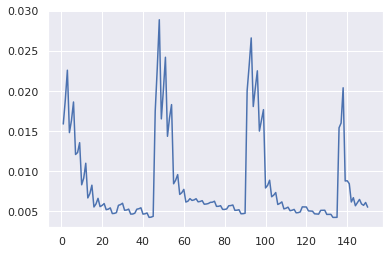

In [9]:
plt.plot(occ_mean_ldr_varsum['pm_cv'])

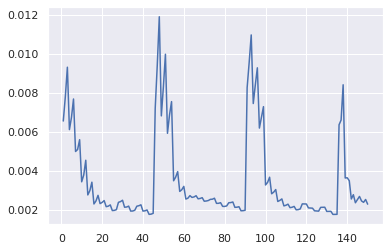

In [10]:
plt.plot(occ_mean_ldr_varsum['ci_precision'])

Yes, there is systematic differences in output measure precision across the input space but these are tiny relative error values. 

In [11]:
occ_mean_ldr_varsum[40:60]

,pm_mean,pm_std,pm_n,pm_cv,ci_halfwidth,ci_precision,unit,pm
scenario,,,,,,,,
41,12.014992,0.056319,25,0.004687,0.023247,0.001935,ldr,occ_mean_ldr
42,12.035699,0.057674,25,0.004792,0.023807,0.001978,ldr,occ_mean_ldr
43,11.827708,0.050187,25,0.004243,0.020716,0.001751,ldr,occ_mean_ldr
44,11.836055,0.050581,25,0.004273,0.020879,0.001764,ldr,occ_mean_ldr
45,11.853579,0.051824,25,0.004372,0.021392,0.001805,ldr,occ_mean_ldr
46,1.367866,0.023892,25,0.017467,0.009862,0.007210,ldr,occ_mean_ldr
47,1.431279,0.032640,25,0.022805,0.013473,0.009413,ldr,occ_mean_ldr
48,1.534697,0.044283,25,0.028855,0.018279,0.011911,ldr,occ_mean_ldr
49,1.315938,0.021723,25,0.016508,0.008967,0.006814,ldr,occ_mean_ldr


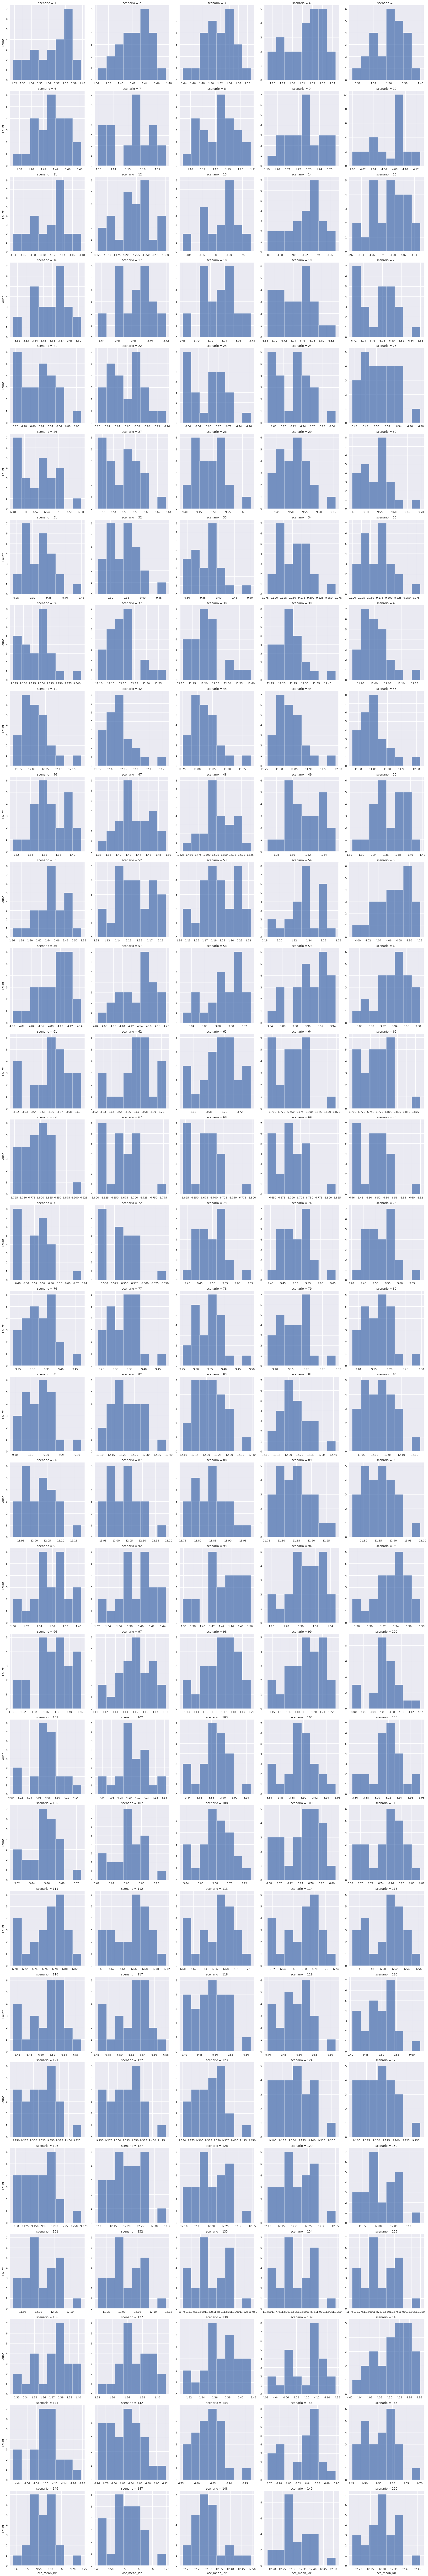

In [12]:
# Key was common_bins=False per https://github.com/mwaskom/seaborn/issues/2472
sns.displot(
    scenario_rep_summary_df, x="occ_mean_ldr", col="scenario", col_wrap=5, bins=8, common_bins=False,
    facet_kws=dict(sharex=False, sharey=False)
)

# Alt approach is
# g = sns.FacetGrid(scenario_rep_summary_df, col="scenario", col_wrap=5, sharex=False, sharey=False)
# g.map(sns.histplot, "occ_mean_ldr")

In [33]:
occ_p95_ldr_varsum = varsum(scenario_rep_summary_df, 'ldr', 'occ_p95_ldr', 0.05)

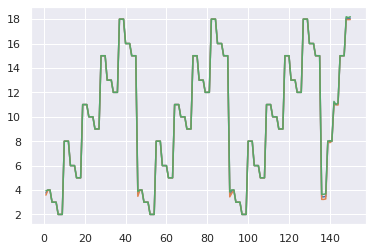

In [34]:
plt.plot(occ_p95_ldr_varsum['pm_mean'])
plt.plot(occ_p95_ldr_varsum['ci_lower'])
plt.plot(occ_p95_ldr_varsum['ci_upper'])

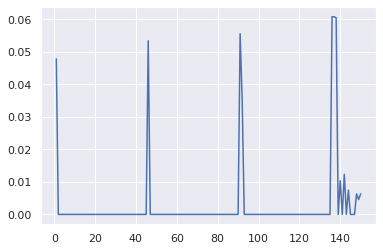

In [15]:
plt.plot(occ_p95_ldr_varsum['ci_precision'])

Hmmm, need to check out the spike values.

**NOTE** Spikes are just due to low traffic scenarios in which the 95'th percentile isn't constant but has two values. Notice all the other scenarios don't have CI's as the sd=0.

In [16]:
occ_p95_ldr_varsum[40:50]

,pm_mean,pm_std,pm_n,pm_min,pm_max,pm_cv,ci_halfwidth,ci_precision,unit,pm
scenario,,,,,,,,,,
41,16.00,0.000000,25,16.0,16.0,0.000000,0.000000,0.000000,ldr,occ_p95_ldr
42,16.00,0.000000,25,16.0,16.0,0.000000,0.000000,0.000000,ldr,occ_p95_ldr
43,15.00,0.000000,25,15.0,15.0,0.000000,0.000000,0.000000,ldr,occ_p95_ldr
44,15.00,0.000000,25,15.0,15.0,0.000000,0.000000,0.000000,ldr,occ_p95_ldr
45,15.00,0.000000,25,15.0,15.0,0.000000,0.000000,0.000000,ldr,occ_p95_ldr
46,3.68,0.476095,25,3.0,4.0,0.129374,0.196522,0.053403,ldr,occ_p95_ldr
47,4.00,0.000000,25,4.0,4.0,0.000000,0.000000,0.000000,ldr,occ_p95_ldr
48,4.00,0.000000,25,4.0,4.0,0.000000,0.000000,0.000000,ldr,occ_p95_ldr
49,3.00,0.000000,25,3.0,3.0,0.000000,0.000000,0.000000,ldr,occ_p95_ldr


In [ ]:
sns.displot(
    scenario_rep_summary_df, x="occ_p95_ldr", col="scenario", col_wrap=5, bins=8, common_bins=False,
    facet_kws=dict(sharex=False, sharey=False)
)

### Occ mean and p95 for PP

In [35]:
occ_mean_pp_varsum = varsum(scenario_rep_summary_df, 'pp', 'occ_mean_pp', 0.05)

In [36]:
occ_p95_pp_varsum = varsum(scenario_rep_summary_df, 'pp', 'occ_p95_pp', 0.05)

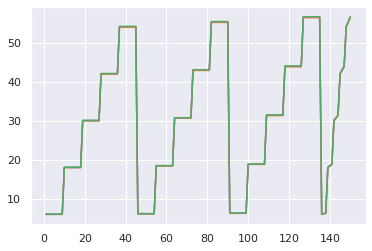

In [37]:
plt.plot(occ_mean_pp_varsum['pm_mean'])
plt.plot(occ_mean_pp_varsum['ci_lower'])
plt.plot(occ_mean_pp_varsum['ci_upper'])

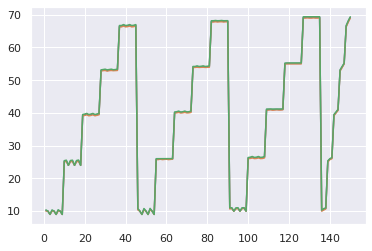

In [38]:
plt.plot(occ_p95_pp_varsum['pm_mean'])
plt.plot(occ_p95_pp_varsum['ci_lower'])
plt.plot(occ_p95_pp_varsum['ci_upper'])

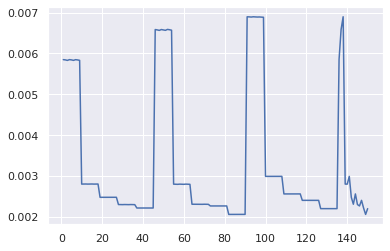

In [18]:
plt.plot(occ_mean_pp_varsum['ci_precision'])

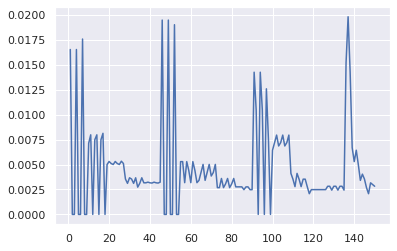

In [19]:
plt.plot(occ_p95_pp_varsum['ci_precision'])

In [ ]:
sns.displot(
    scenario_rep_summary_df, x="occ_mean_pp", col="scenario", col_wrap=5, bins=8, common_bins=False,
    facet_kws=dict(sharex=False, sharey=False)
)

### Pct waitq in LDR

The infinite capacity scenarios are irrelevant and obscure the plot details.

In [51]:
pct_waitq_ldr_varsum = varsum(scenario_rep_summary_df, 'ldr', 'pct_waitq_ldr', 0.05)
waitq_ldr_mean_varsum = varsum(scenario_rep_summary_df, 'ldr', 'waitq_ldr_mean', 0.05)
waitq_ldr_p95_varsum = varsum(scenario_rep_summary_df, 'ldr', 'waitq_ldr_p95', 0.05)

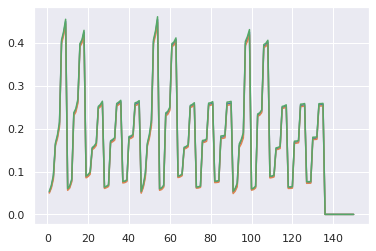

In [40]:
plt.plot(pct_waitq_ldr_varsum['pm_mean'])
plt.plot(pct_waitq_ldr_varsum['ci_lower'])
plt.plot(pct_waitq_ldr_varsum['ci_upper'])

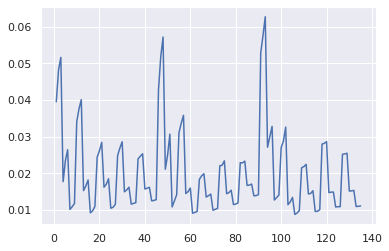

In [22]:
plt.plot(pct_waitq_ldr_varsum.loc[:135]['ci_precision'])

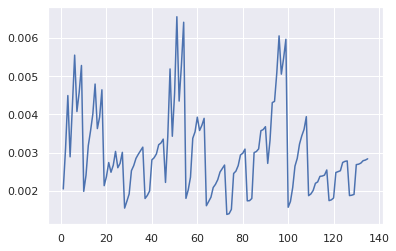

In [24]:
plt.plot(pct_waitq_ldr_varsum.loc[:135]['ci_halfwidth'])

In [25]:
waitq_ldr_mean_varsum = varsum(scenario_rep_summary_df, 'ldr', 'waitq_ldr_mean', 0.05)

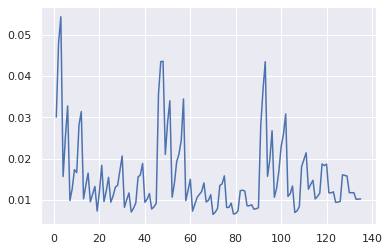

In [26]:
plt.plot(waitq_ldr_mean_varsum.loc[:135]['ci_precision'])

### Pct blocked by PP

In [41]:
pct_blocked_by_pp_varsum = varsum(scenario_rep_summary_df, 'pp', 'pct_blocked_by_pp', 0.05)

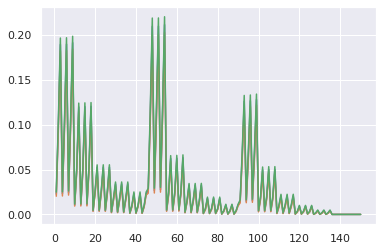

In [42]:
plt.plot(pct_blocked_by_pp_varsum['pm_mean'])
plt.plot(pct_blocked_by_pp_varsum['ci_lower'])
plt.plot(pct_blocked_by_pp_varsum['ci_upper'])

In [28]:
pct_blocked_by_pp_varsum[120:]

,pm_mean,pm_std,pm_n,pm_min,pm_max,pm_cv,ci_halfwidth,ci_precision,unit,pm
scenario,,,,,,,,,,
121,0.000463,0.000423,25,0.000023,0.001613,0.913835,0.000175,0.377213,pp,pct_blocked_by_pp
122,0.002922,0.001119,25,0.000863,0.005521,0.382892,0.000462,0.158050,pp,pct_blocked_by_pp
123,0.009240,0.001979,25,0.004633,0.014178,0.214212,0.000817,0.088423,pp,pct_blocked_by_pp
124,0.000456,0.000422,25,0.000000,0.001636,0.926815,0.000174,0.382570,pp,pct_blocked_by_pp
125,0.002888,0.001105,25,0.000840,0.005476,0.382592,0.000456,0.157926,pp,pct_blocked_by_pp
126,0.009236,0.001957,25,0.004587,0.014178,0.211871,0.000808,0.087456,pp,pct_blocked_by_pp
127,0.000155,0.000201,25,0.000000,0.000743,1.298539,0.000083,0.536010,pp,pct_blocked_by_pp
128,0.001468,0.000709,25,0.000177,0.003324,0.483414,0.000293,0.199543,pp,pct_blocked_by_pp
129,0.004356,0.001284,25,0.001757,0.007144,0.294657,0.000530,0.121628,pp,pct_blocked_by_pp


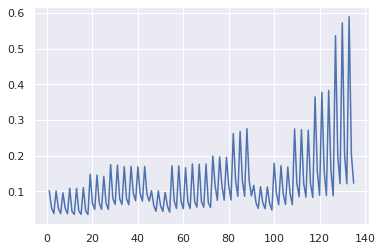

In [46]:
plt.plot(pct_blocked_by_pp_varsum.loc[:135]['ci_precision'])

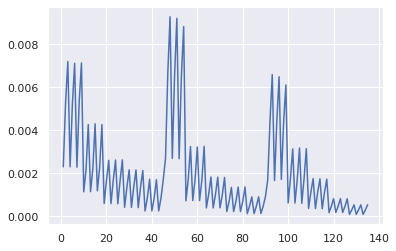

In [41]:
plt.plot(pct_blocked_by_pp_varsum.loc[:135]['ci_halfwidth'])

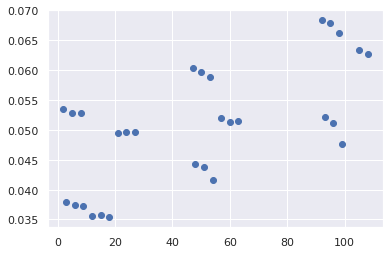

In [25]:
plt.scatter(pct_blocked_by_pp_varsum.loc[pct_blocked_by_pp_varsum['pm_mean'] >= 0.05].index,
           pct_blocked_by_pp_varsum.loc[pct_blocked_by_pp_varsum['pm_mean'] >= 0.05]['ci_precision'])

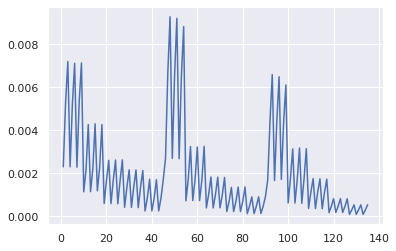

In [30]:
plt.plot(pct_blocked_by_pp_varsum.loc[:135]['ci_halfwidth'])

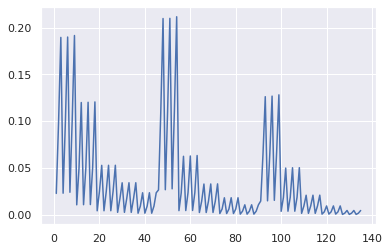

In [31]:
plt.plot(pct_blocked_by_pp_varsum.loc[:135]['pm_mean'])

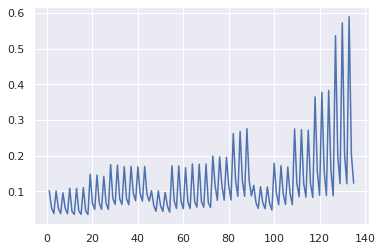

In [33]:
plt.plot((pct_blocked_by_pp_varsum.loc[:135]['ci_halfwidth'] * 100) / (pct_blocked_by_pp_varsum.loc[:135]['pm_mean'] * 100))

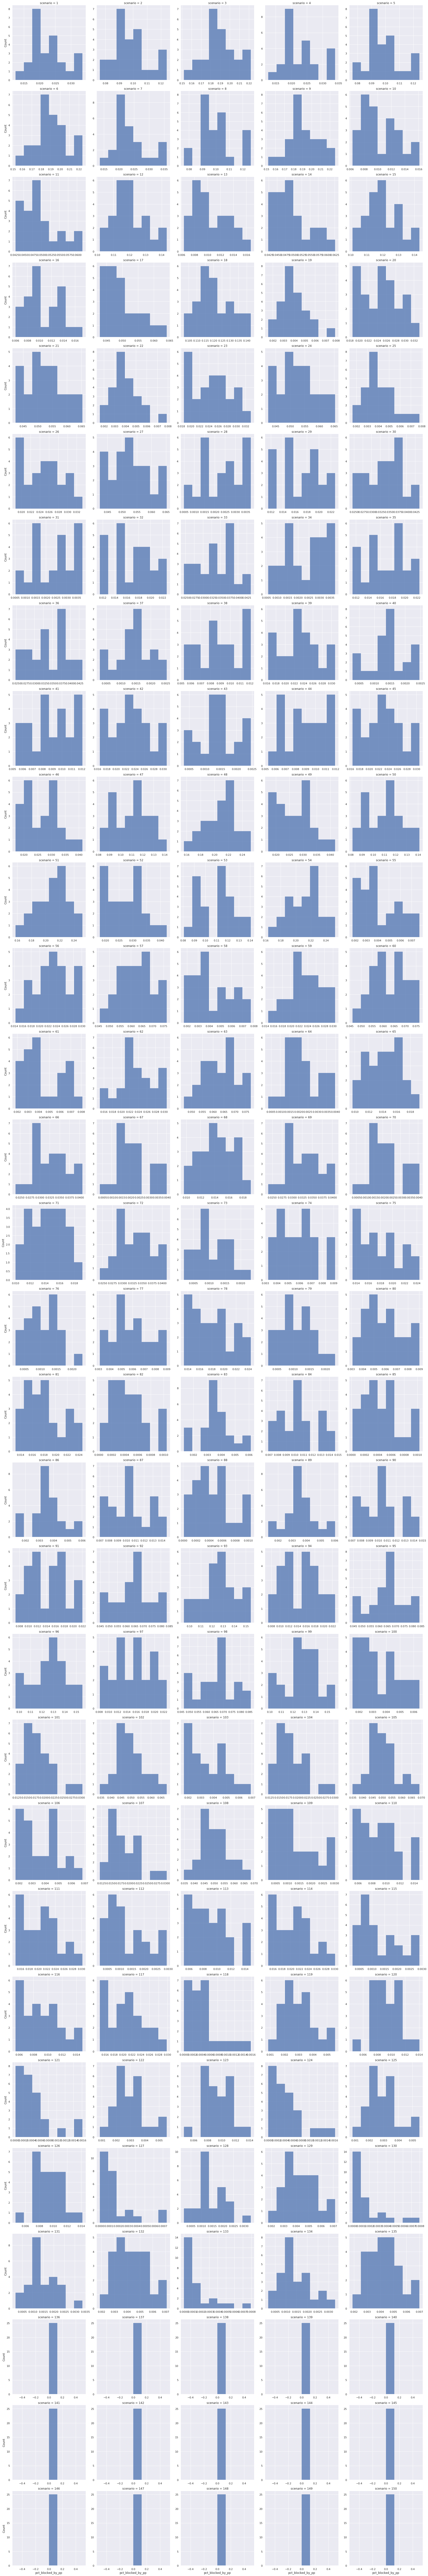

In [37]:
# Key was common_bins=False per https://github.com/mwaskom/seaborn/issues/2472
sns.displot(
    scenario_rep_summary_df, x="pct_blocked_by_pp", col="scenario", col_wrap=5, bins=8, common_bins=False,
    facet_kws=dict(sharex=False, sharey=False)
)

# Alt approach is
# g = sns.FacetGrid(scenario_rep_summary_df, col="scenario", col_wrap=5, sharex=False, sharey=False)
# g.map(sns.histplot, "occ_mean_ldr")

So, prob of being blocked in LDR by PP is most difficult performance measure to estimate - has largest cv. For many of the scenarios, the gap between the minimum mean and maximum mean is only a few points (one point = 0.01). However, for some scenarios, this gap is is as high as ten points. See scatters below. The large gaps are correlated with large probabilities of being blocked. Makes sense, the higher the congestion, the higher the variance in the estimated mean prob of blocking. 

Also not surprising, the scenarios with the largest (min, max) gaps are those with target accommodation of 0.75 for pp along with low volume (and hence, smaller unit sizes - we are losing the economies of scale benefits).

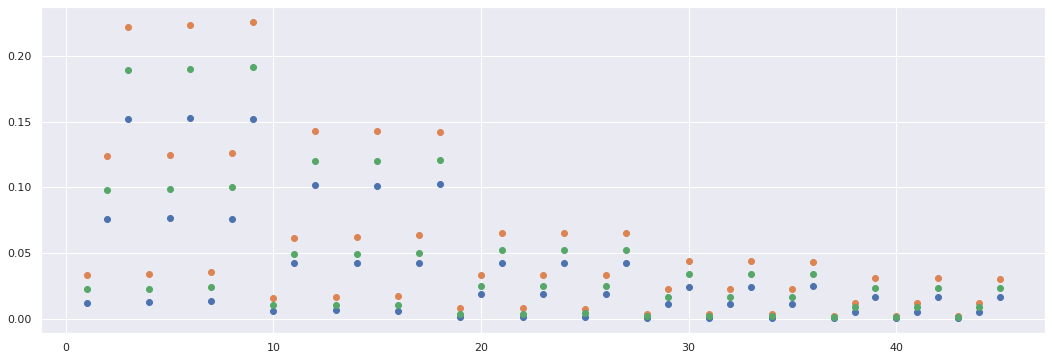

In [63]:
scen_lower = 1
scen_upper = 45

plt.subplots(figsize=(18, 6))
plt.scatter(pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper].index, pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper]['pm_min'])
plt.scatter(pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper].index, pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper]['pm_max'])
plt.scatter(pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper].index, pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper]['pm_mean'])

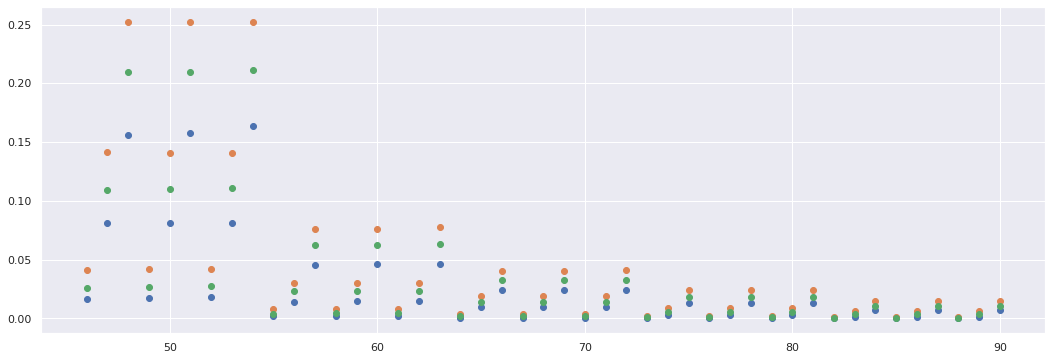

In [68]:
scen_lower = 46
scen_upper = 90

plt.subplots(figsize=(18, 6))
plt.scatter(pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper].index, pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper]['pm_min'])
plt.scatter(pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper].index, pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper]['pm_max'])
plt.scatter(pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper].index, pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper]['pm_mean'])

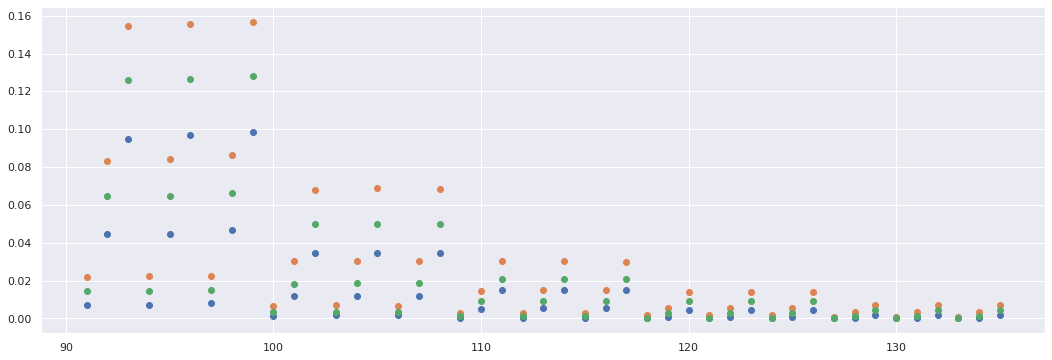

In [67]:
scen_lower = 91
scen_upper = 135

plt.subplots(figsize=(18, 6))
plt.scatter(pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper].index, pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper]['pm_min'])
plt.scatter(pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper].index, pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper]['pm_max'])
plt.scatter(pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper].index, pct_blocked_by_pp_varsum.loc[scen_lower:scen_upper]['pm_mean'])

In [29]:
pct_blocked_by_pp_varsum.to_csv('pct_blocked_by_pp_varsum.csv')

Seems like we need more replications. Let's run scenario 3 (low volume, low pp accom, high blocking prob, high uncertainty in estimating blocking prob) for 50 reps. This will also force me to get my machinery order to be able to do this and process the outputs efficiently for a single scenario.

In [26]:
df = pd.read_csv('./output/scenario_rep_stats_summary_scen3_50reps.csv')
df

,scenario,rep,timestamp,num_days,num_visits_obs,num_visits_ldr,num_visits_pp,num_visits_csect,planned_los_mean_obs,actual_los_mean_obs,...,occ_p95_obs,occ_p95_ldr,occ_p95_csect,occ_p95_pp,pct_waitq_ldr,waitq_ldr_mean,waitq_ldr_p95,pct_blocked_by_pp,blocked_by_pp_mean,blocked_by_pp_p95
0,3,1,2021-08-09 21:10:06.756234,2300.0,6232.0,6233.0,6241.0,1269.0,2.400998,2.824685,...,1.0,4.0,1.0,9.0,0.078453,5.399627,17.428804,0.179619,10.517798,26.720613
1,3,2,2021-08-09 21:10:10.054142,2300.0,6247.0,6251.0,6260.0,1223.0,2.380686,2.953629,...,1.0,4.0,1.0,9.0,0.087186,6.693274,21.825798,0.191853,11.293596,28.896407
2,3,3,2021-08-09 21:10:09.719130,2300.0,6357.0,6357.0,6363.0,1305.0,2.383710,3.124330,...,2.0,4.0,1.0,9.0,0.101463,7.299407,24.628424,0.212007,12.386537,31.295151
3,3,4,2021-08-09 21:10:07.957548,2300.0,6219.0,6222.0,6230.0,1197.0,2.393005,2.907613,...,1.0,4.0,1.0,9.0,0.085342,6.027016,20.409324,0.186356,10.760946,27.396378
4,3,5,2021-08-09 21:10:06.214249,2300.0,6316.0,6316.0,6323.0,1200.0,2.436710,3.058382,...,2.0,4.0,1.0,9.0,0.091514,6.793213,21.935770,0.187727,11.649499,29.447743
5,3,6,2021-08-09 21:10:06.002683,2300.0,6314.0,6314.0,6319.0,1252.0,2.451905,2.944913,...,2.0,4.0,1.0,9.0,0.085841,5.743281,16.820722,0.181358,10.869167,26.175330
6,3,7,2021-08-09 21:10:09.481768,2300.0,6371.0,6372.0,6377.0,1288.0,2.369696,2.971862,...,2.0,4.0,1.0,9.0,0.088983,6.766145,20.118679,0.202289,11.507440,28.480433
7,3,8,2021-08-09 21:10:05.791165,2300.0,6412.0,6412.0,6418.0,1317.0,2.367864,3.059055,...,2.0,4.0,1.0,9.0,0.096538,7.159796,22.717539,0.217046,12.417994,29.716934
8,3,9,2021-08-09 21:10:08.280035,2300.0,6138.0,6140.0,6148.0,1205.0,2.440804,2.867501,...,1.0,4.0,1.0,9.0,0.072964,5.846131,19.149698,0.170462,11.301847,27.794888
9,3,10,2021-08-09 21:10:06.107694,2300.0,6328.0,6331.0,6334.0,1338.0,2.447693,3.049609,...,2.0,4.0,1.0,9.0,0.088296,6.813816,24.744200,0.200032,11.964758,32.462999


In [27]:
pct_blocked_by_pp_varsum_50 = varsum(df, 'pp', 'pct_blocked_by_pp', 0.05)
pct_blocked_by_pp_varsum_50

,pm_mean,pm_std,pm_n,pm_min,pm_max,pm_cv,ci_halfwidth,ci_precision,unit,pm
scenario,,,,,,,,,,
3,0.191029,0.016554,50,0.152088,0.227057,0.086658,0.004705,0.024628,pp,pct_blocked_by_pp


Actually, 50 reps only reduced the ci_halfwidth from 0.007 to 0.004.

In [43]:
blocked_by_pp_mean_varsum = varsum(scenario_rep_summary_df, 'pp', 'blocked_by_pp_mean', 0.05)

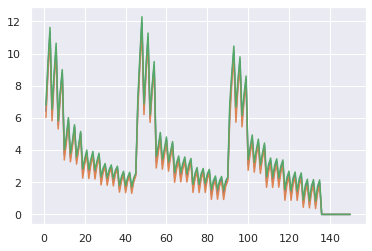

In [44]:
plt.plot(blocked_by_pp_mean_varsum['pm_mean'])
plt.plot(blocked_by_pp_mean_varsum['ci_lower'])
plt.plot(blocked_by_pp_mean_varsum['ci_upper'])

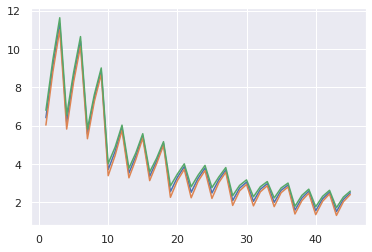

In [45]:
plt.plot(blocked_by_pp_mean_varsum['pm_mean'][:45])
plt.plot(blocked_by_pp_mean_varsum['ci_lower'][:45])
plt.plot(blocked_by_pp_mean_varsum['ci_upper'][:45])

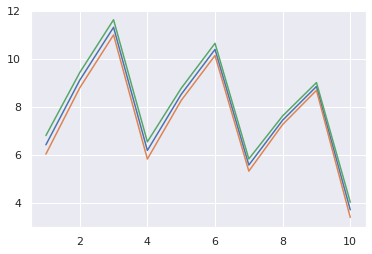

In [46]:
plt.plot(blocked_by_pp_mean_varsum['pm_mean'][:10])
plt.plot(blocked_by_pp_mean_varsum['ci_lower'][:10])
plt.plot(blocked_by_pp_mean_varsum['ci_upper'][:10])

In [47]:
blocked_by_pp_p95_varsum = varsum(scenario_rep_summary_df, 'pp', 'blocked_by_pp_p95', 0.05)

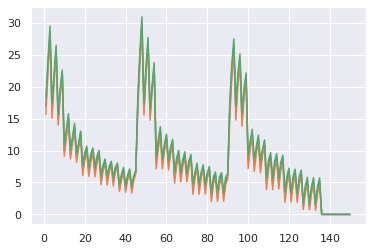

In [48]:
plt.plot(blocked_by_pp_p95_varsum['pm_mean'])
plt.plot(blocked_by_pp_p95_varsum['ci_lower'])
plt.plot(blocked_by_pp_p95_varsum['ci_upper'])

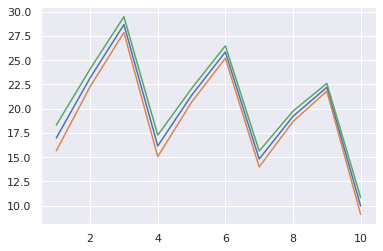

In [49]:
plt.plot(blocked_by_pp_p95_varsum['pm_mean'][:10])
plt.plot(blocked_by_pp_p95_varsum['ci_lower'][:10])
plt.plot(blocked_by_pp_p95_varsum['ci_upper'][:10])